# Multi-level strain optimization approaches

Several strain design approaches use MILPs with nested optimization to enforce growth-coupled production. As the first nested optimization algorithm, OptKnock aimed to resolve the conflict between the microbial objective of fast growth with the engineering goal of fast production. It therefore constructs a max-max problem for the maximization of product synthesis under the assumption that the cell itself, will maximize its growth rate. One problem is that this formulation leads to overly optimistic strain designs, since it assumes that a cell would maximize production when attaining its maximal growth rate. In the worst case, however (potentially growth coupled prodcution), a cell might turn off production completely.

Successors of OptKnock, such as RobustKnock and OptCouple have overcome this problem since they guarantee production at maximum growth (weakly growth-coupled production). In the following sections we will explain how one can compute strain designs with OptKnock, RobustKnock and OptCouple, and how these methods can be combined with the minimial cut set approach.

In [1]:
import straindesign as sd
import cobra

ecc = cobra.io.load_model('e_coli_core')

Set parameter Username
Academic license - for non-commercial use only - expires 2022-09-03


## Example 9: OptKnock strain design

Optknock is based on a bi-level optimization problem:

\begin{array}{ll}
    \text{maximize} \; & v_{production} \\
    \text{subject to}  & \begin{array}{ll}
        \text{maximize} &  v_{biomass} \hspace{10em} \\
        \text{subject to} & \mathbf{S~v=0} \\
        & v_{BM} \ge v_{BM}^{min} \\
        & (1-z_i)\cdot lb_i \le v_i \le (1-z_i)\cdot ub_i, ~\forall i\in\{1,\dots,n\}\\
        &\sum z_i \le \text{maxKOs}\\
        &z_i \in \{0,1\}
\end{array}\end{array}

The nested optimization is translated into a single-layer problem and can then be solved as a mixed-integer linear problem (MILP).

Translating the nested optimization into a single level optimization yields:

\begin{gathered}
\text{maximize} \; v_{production} \\
\text{subject to} \\
\begin{array}{lll}
    \begin{bmatrix}
        ~~\mathbf G & \mathbf 0 & \mathbf 0 \\
        ~~\mathbf D & \mathbf 0 & \mathbf 0 \\
        \mathbf{-c^\intercal}~ & \mathbf{g^\intercal} & \mathbf 0 \\
        ~~\mathbf 0 & \mathbf{G^\intercal} & \mathbf{I_{KO}} \\
    \end{bmatrix} &
    \begin{bmatrix}
        \mathbf{v} \\ \mathbf{y} \\ \mathbf{s}
    \end{bmatrix} &
    \begin{matrix}
        \le \\ \le \\ \le \\ =
    \end{matrix}
    \begin{bmatrix}\mathbf g \\ \mathbf d \\ 0 \\ \mathbf c\end{bmatrix} \\
\end{array} \\
\forall i: z_i = 1 \rightarrow v_i = 0 \\
\forall i: z_i = 0 \rightarrow s_i = 0 \\
\sum z_i \le MaxNoKO \\
\mathbf{y\ge 0}, \hskip 1em z\in\{0,1\}
\end{gathered}


The steps of translating a bi-level problem to a MILP are automated in StrainDesign. In the following, we will compute OptKnock strain designs using ``e_coli_core``.

An advantage of OptKnock strain designs is that they often allow for higher maximal growth rate. However, the predicted strain designs are often overly optimistic since they imply that the cells are able to actually reach their stoichiometrically highest possible growth rate and then also tune teir metabolism towards production. OptKnock strain design might be preferred if the production pathway known to well expressed and active, even without introducing knockouts. OptKnock may then assure that laboratory evolution selects against production.

We, again use the example of 1,4-BDO production. Hence, we first need to introduce the 1,4-BDO pathway again into the e_coli_core model and ensure that it is operational.

In [2]:
# Create copy of model to which pathway will be added
ecc_14bdo = ecc.copy()

# Add metabolites to model
ecc_14bdo.add_metabolites([ cobra.Metabolite('sucsal_c'),# Succinic semialdehyde
                            cobra.Metabolite('4hb_c'),   # 4-Hydroxybutanoate
                            cobra.Metabolite('4hbcoa_c'),# 4-Hydroxybutyryl-CoA
                            cobra.Metabolite('4hbal_c'), # 4-Hydroxybutanal
                            cobra.Metabolite('14bdo_c'), # Butane-1,4-diol (cytopl.)
                            cobra.Metabolite('14bdo_p'), # Butane-1,4-diol (peripl.)
                            cobra.Metabolite('14bdo_e')  # Butane-1,4-diol (extrac.)
                            ])

# Create reactions
SSCOARx    = cobra.Reaction('SSCOARx')
HBD        = cobra.Reaction('4HBD')
HBCT       = cobra.Reaction('4HBCT')
HBDH       = cobra.Reaction('4HBDH')
HBDx       = cobra.Reaction('4HBDx')
BDOtpp     = cobra.Reaction('14BDOtpp')
BDOtex     = cobra.Reaction('14BDOtex')
EX_14bdo_e = cobra.Reaction('EX_14bdo_e')

# Add reactions to model
ecc_14bdo.add_reactions([SSCOARx,
                        #  AKGDC,
                         HBD,
                         HBCT,
                         HBDH,
                         HBDx,
                         BDOtpp,
                         BDOtex,
                         EX_14bdo_e])

# Define reaction equations
SSCOARx.reaction    = '1 h_c + 1 nadph_c + 1 succoa_c -> 1 coa_c + 1 nadp_c + 1 sucsal_c'
HBD.reaction        = '1 h_c + 1 nadh_c + 1 sucsal_c  -> 1 4hb_c + 1 nad_c'
HBCT.reaction       = '1 4hb_c + 1 accoa_c            -> 1 4hbcoa_c + 1 ac_c'
HBDH.reaction       = '1 4hbcoa_c + 1 h_c + 1 nadh_c  -> 1 4hbal_c + 1 coa_c + 1 nad_c'
HBDx.reaction       = '1 4hbal_c + 1 h_c + 1 nadh_c   -> 1 14bdo_c + 1 nad_c'
BDOtpp.reaction     = '1 14bdo_c                      -> 1 14bdo_p'
BDOtex.reaction     = '1 14bdo_p                      -> 1 14bdo_e'
EX_14bdo_e.reaction = '1 14bdo_e                      ->'

# Verify that pathway is operational
sol = sd.fba(ecc_14bdo,obj='EX_14bdo_e',obj_sense='max')
print(f"Maximum possible 1,4-BDO synthesis rate: {sol.objective_value}.")

Read LP format model from file C:\Users\phili\AppData\Local\Temp\tmpr24bei36.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
Maximum possible 1,4-BDO synthesis rate: 10.239127272727272.


We then set up the strain design module for computing OptKnock strain desings. The OptKnock module consists of an outer and inner objective and additional constrains. The additional constraints are used to enforce the minimal desired growth rate.

In [74]:
module_optknock = sd.SDModule(ecc_14bdo,sd.names.OPTKNOCK,
                              inner_objective='BIOMASS_Ecoli_core_w_GAM',
                              outer_objective='EX_14bdo_e',
                              constraints='BIOMASS_Ecoli_core_w_GAM >= 0.5')

We then call the strain design function with the constructed module. Since OptKnock uses an outer objective, we should use the solution approach 'BEST' to enforce optimality.

In [75]:
import logging
logging.basicConfig(level=logging.INFO)
# Compute strain designs
sols = sd.compute_strain_designs(ecc_14bdo,
                                 sd_modules = module_optknock,
                                 time_limit = 300,
                                 max_solutions = 1,
                                 max_cost = 30,
                                 solution_approach = sd.names.BEST,
                                 gene_kos = True)
# Print solutions
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.gene_sd)} solutions in the uncompressed netork.")
print(f"Example knockout set: {[s for s in sols.gene_sd[0]]}")

INFO:root:Preparing strain design computation.
INFO:root:  Using gurobi for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (137 genes, 69 gpr rules).
INFO:root:  Simplifyied to 80 genes and 45 gpr rules.
INFO:root:  Extending metabolic network with gpr associations.
INFO:root:Compressing Network (250 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 128 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Reduced to 107 reactions.
INFO:root:  Compression 3: Applying compression from EFM-tool module.
INFO:root:  Reduced to 99 reactions.
INFO:root:  Compression 4: Lumping parallel reactions.
INFO:root:  Reduced to 98 reac

One compressed solution with cost 10.0 found and expanded to 4 solutions in the uncompressed netork.
Example knockout set: ['pgi', 'gdhA', 'kgtP', 'aceA', 'purT', 'ackA', 'tdcD', 'pykF', 'pykA', 'sucC']


We can now compare the computed strain design to the wild type and the minimal enforced growth rate. As OptKnock is rate instead of yield based, we plot our strain designs in the production envelope.

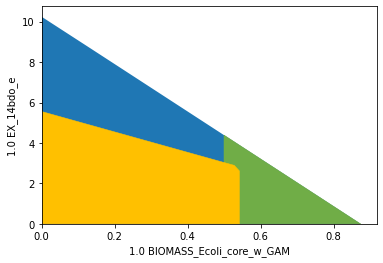

In [79]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               show=False);
# Plot minimal enforced growth rate
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               constraints='BIOMASS_Ecoli_core_w_GAM>=0.5',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# OptKnock design plot
knockouts = [[{s:1.0},'=',0.0] for s in sols.reaction_sd[0]]
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=knockouts,
                                               show=False);
plot2.set_facecolor('#FFC000')
plot2.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot2.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot2.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

The computed strain design generates a pGCP strain design with a relatively high maximal growth rate, however, at the cost of relatively many knockouts. The plot shows that OptKnock has exploited all means to improve maximal production at maximum growth. The maximum growth rate is only slightly above the demanded minimum. 

## Example 10: OptKock-like strain designs with a given productivity goal

OptKnock may also be used with the 'ANY' solution approach. In this case, the global constraint of maximal production is omitted. This speeds up the computation process, but does not produc strain designs with globally maximal production. For this approach, we have to set another constraint to specify our minimal production potential. Here, we use a rate minimum of 3, but one can as well use a lower product yield limit, as in the MCS computations.

As a result, we obtain a pGCP strain design. The 

## RobustKnock

## OptCouple

## Combined nested-MCS combinations